In [2]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


In [7]:
variants = pd.read_csv('variants_full.csv')


In [9]:
def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id']:
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa


def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

In [10]:
gene_list = variants['gene'].unique()
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
# gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)

mic_series = np.log2(mic_aa['EMB_MIC'])
mic_series += 1
sample_ids = mic_aa['ENA_RUN']

train_data, test_data, train_target, test_target = data_split(aa_array, mic_series)
train_target = train_target.to_frame()
test_target = test_target.to_frame()
target_min, target_max = mic_series.min(), mic_series.max()

/tmp/ipykernel_77715/3430933229.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_77715/3430933229.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|██████████| 11362/11362 [00:01<00:00, 9105.02it/s] 
/tmp/ipykernel_77715/2826833542.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

## cornloss weighting

In [ ]:
train_target_counts = torch.from_numpy(train_target.values).flatten()
# train_target_counts = torch.tensor([0,1,2])


In [ ]:
# import torch
# import torch.nn.functional as F

# def compute_class_weights(y_train, num_classes):
#     class_counts = torch.bincount(y_train, minlength=num_classes)
#     print(class_counts)
#     class_weights = 1.0 / class_counts.float()
#     class_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
#     return class_weights

# # Example usage
# num_classes = 3
# class_weights = compute_class_weights(train_target_counts, num_classes)
# print(class_weights)

RuntimeError: "bincount_cpu" not implemented for 'Double'

In [ ]:
# def loss_corn(logits, y_train, num_classes, class_weights):
#     sets = []
#     for i in range(num_classes - 1):
#         label_mask = y_train > i - 1
#         label_tensor = (y_train[label_mask] > i).to(torch.int64)
#         sets.append((label_mask, label_tensor))

#     num_examples = 0
#     losses = 0.
#     for task_index, s in enumerate(sets):
#         train_examples = s[0]
#         train_labels = s[1]

#         if len(train_labels) < 1:
#             continue

#         num_examples += len(train_labels)
#         pred = logits[train_examples, task_index]

#         # Apply class weights
#         weights = class_weights[train_labels].to(logits.device)
        
#         loss = -torch.sum(weights * (F.logsigmoid(pred) * train_labels +
#                                      (F.logsigmoid(pred) - pred) * (1 - train_labels)))
#         losses += loss
#     return losses / num_examples

# # Example usage
# # logits = torch.randn(9, 2).cuda()  # Example logits tensor
# # y_train = torch.tensor([0, 1, 2, 0, 1, 2, 2, 1, 0]).cuda()  # Example training labels
# # class_weights = compute_class_weights(y_train.cpu(), num_classes).cuda()

# # loss = loss_corn(logits, y_train, num_classes, class_weights)
# # print(f"Loss: {loss.item()}")


## Dataset

In [11]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%
def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

 


In [17]:
       
from torch.optim.lr_scheduler import CyclicLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [514112]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x = self.prediction_layer(x)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

In [13]:
model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
# conv_dropout_rate=conv_dropout_rate,
# dense_dropout_rate=dense_dropout_rate
).to(device)


## Single run

  7%|▋         | 29/400 [07:15<1:32:45, 15.00s/it]

Epoch 29
Training loss: 0.19949860870838165
Validation loss: 1.7234461307525635


 14%|█▍        | 58/400 [14:31<1:25:33, 15.01s/it]

Epoch 58
Training loss: 0.19762593507766724
Validation loss: 0.4586509168148041


 22%|██▏       | 87/400 [21:48<1:18:43, 15.09s/it]

Epoch 87
Training loss: 0.1951773464679718
Validation loss: 0.18890661001205444


 29%|██▉       | 116/400 [29:05<1:11:15, 15.05s/it]

Epoch 116
Training loss: 0.1945483535528183
Validation loss: 0.19004708528518677


 36%|███▋      | 145/400 [36:21<1:03:54, 15.04s/it]

Epoch 145
Training loss: 0.19401974976062775
Validation loss: 0.2807804048061371


 44%|████▎     | 174/400 [43:37<56:37, 15.03s/it]  

Epoch 174
Training loss: 0.19347432255744934
Validation loss: 0.20677605271339417


 51%|█████     | 203/400 [50:54<49:29, 15.08s/it]

Epoch 203
Training loss: 0.19237308204174042
Validation loss: 1.8794150352478027


 58%|█████▊    | 232/400 [1:01:06<1:02:05, 22.18s/it]

Epoch 232
Training loss: 0.1923046112060547
Validation loss: 0.19149938225746155


 65%|██████▌   | 261/400 [1:15:21<1:13:50, 31.87s/it]

Epoch 261
Training loss: 0.19114437699317932
Validation loss: 0.21039250493049622


 72%|███████▎  | 290/400 [1:30:41<58:12, 31.75s/it]  

Epoch 290
Training loss: 0.190524160861969
Validation loss: 0.18899603188037872


 80%|███████▉  | 319/400 [1:46:01<42:53, 31.77s/it]

Epoch 319
Training loss: 0.1902603656053543
Validation loss: 0.46619826555252075


 87%|████████▋ | 348/400 [2:01:27<28:31, 32.91s/it]

Epoch 348
Training loss: 0.19008028507232666
Validation loss: 0.18414142727851868


 94%|█████████▍| 377/400 [2:13:04<06:03, 15.78s/it]

Epoch 377
Training loss: 0.18923571705818176
Validation loss: 0.1955670267343521


100%|██████████| 400/400 [2:19:07<00:00, 20.87s/it]


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 1e-06
Weight decay: 1e-08
Accuracy: 0.12049252418645559
Mae: 2.133685136323659
F1 Score: 0.025914404730838957
conf_matrix: [[  0   0   0   0 112   0]
 [  0   0   0   0 397   0]
 [  0   0   0   0 296   0]
 [  0   0   0   0 149   0]
 [  0   0   0   0 137   0]
 [  0   0   0   0  46   0]]
Doubling Dilution Accuracy: 0.29199648197009676


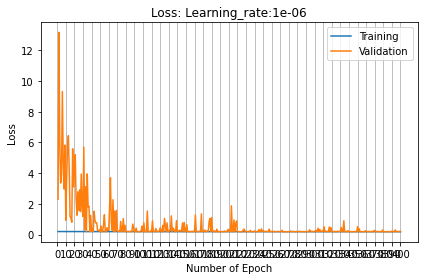

In [18]:
#input parameter
lr = 1e-6
epoch = 400
conv_dropout_rate=0.1
dense_dropout_rate=0
weight_decay=1e-8
######################################

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        # loss_train = loss_corn(pred, y_batch, 3, class_weights)
        loss_train = criterion(pred,y_batch)
        # print(pred)
        # print(y_batch)
        # print(loss_train)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate
        # break
    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            loss_test = criterion(pred,y_batch)
            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            # loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e%29 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

## Hypterparameter tuning

lr: 1e-06 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.1 weight_decay: 0


 12%|█▎        | 50/400 [02:33<18:00,  3.09s/it]

Epoch 50
Training loss: 0.14512404799461365
Validation loss: 0.14181280136108398


 25%|██▌       | 100/400 [05:06<15:05,  3.02s/it]

Epoch 100
Training loss: 0.13658545911312103
Validation loss: 0.1411546915769577


 38%|███▊      | 150/400 [07:41<12:58,  3.11s/it]

Epoch 150
Training loss: 0.1325596421957016
Validation loss: 0.14208084344863892


 50%|█████     | 200/400 [10:15<10:08,  3.04s/it]

Epoch 200
Training loss: 0.12968821823596954
Validation loss: 0.14227938652038574


 62%|██████▎   | 250/400 [12:50<07:44,  3.09s/it]

Epoch 250
Training loss: 0.12922421097755432
Validation loss: 0.13856267929077148


 75%|███████▌  | 300/400 [15:23<05:03,  3.03s/it]

Epoch 300
Training loss: 0.1271374374628067
Validation loss: 0.14325588941574097


 88%|████████▊ | 350/400 [17:57<02:36,  3.13s/it]

Epoch 350
Training loss: 0.12758894264698029
Validation loss: 0.14209620654582977


100%|██████████| 400/400 [20:34<00:00,  3.09s/it]

Epoch 400
Training loss: 0.1262592226266861
Validation loss: 0.13970555365085602


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-06
Weight decay: 0
Accuracy: 0.48717948717948717
Mae: 0.6419098143236074
F1 Score: 0.4398898151775065
conf_matrix: [[ 25  76   5   5   0   1]
 [ 36 317  26  10   4   1]
 [ 27 207  31  23   3   2]
 [  4  22   5  74  41   3]
 [  2  11   0  30  78  16]
 [  0   2   0   5  13  26]]
Doubling Dilution Accuracy: 0.905393457117595
lr: 1e-06 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.2 weight_decay: 0


 12%|█▎        | 50/400 [02:33<18:07,  3.11s/it]

Epoch 50
Training loss: 0.16021989285945892
Validation loss: 0.15311983227729797


 25%|██▌       | 100/400 [05:16<20:28,  4.09s/it]

Epoch 100
Training loss: 0.14734810590744019
Validation loss: 0.14596706628799438


 38%|███▊      | 150/400 [08:51<18:12,  4.37s/it]

Epoch 150
Training loss: 0.14199569821357727
Validation loss: 0.1448957324028015


 50%|█████     | 200/400 [12:26<14:09,  4.25s/it]

Epoch 200
Training loss: 0.1372901350259781
Validation loss: 0.14409920573234558


 62%|██████▎   | 250/400 [16:02<10:11,  4.08s/it]

Epoch 250
Training loss: 0.13620588183403015
Validation loss: 0.14237281680107117


 75%|███████▌  | 300/400 [19:37<07:08,  4.29s/it]

Epoch 300
Training loss: 0.13350218534469604
Validation loss: 0.14211229979991913


 88%|████████▊ | 350/400 [23:31<03:45,  4.51s/it]

Epoch 350
Training loss: 0.13216587901115417
Validation loss: 0.14377187192440033


100%|██████████| 400/400 [27:07<00:00,  4.07s/it]

Epoch 400
Training loss: 0.13075704872608185
Validation loss: 0.1423320770263672


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-06
Weight decay: 0
Accuracy: 0.46684350132625996
Mae: 0.6702033598585323
F1 Score: 0.4336030238728321
conf_matrix: [[ 28  74   5   3   1   1]
 [ 58 287  34   9   5   1]
 [ 36 192  38  23   2   2]
 [  6  19   5  77  36   6]
 [  3   8   2  32  65  27]
 [  0   2   0   3   8  33]]
Doubling Dilution Accuracy: 0.8992042440318302
lr: 1e-06 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.3 weight_decay: 0


 12%|█▎        | 50/400 [03:30<24:11,  4.15s/it]

Epoch 50
Training loss: 0.16156631708145142
Validation loss: 0.15317150950431824


 25%|██▌       | 100/400 [07:01<20:40,  4.14s/it]

Epoch 100
Training loss: 0.1532468944787979
Validation loss: 0.1500134915113449


 38%|███▊      | 150/400 [10:40<17:59,  4.32s/it]

Epoch 150
Training loss: 0.14894221723079681
Validation loss: 0.14792926609516144


 50%|█████     | 200/400 [14:51<18:04,  5.42s/it]

Epoch 200
Training loss: 0.14633281528949738
Validation loss: 0.14835572242736816


 62%|██████▎   | 250/400 [18:54<11:33,  4.62s/it]

Epoch 250
Training loss: 0.14358678460121155
Validation loss: 0.14584991335868835


 75%|███████▌  | 300/400 [22:47<07:47,  4.67s/it]

Epoch 300
Training loss: 0.14171798527240753
Validation loss: 0.14566586911678314


 88%|████████▊ | 350/400 [26:42<04:01,  4.83s/it]

Epoch 350
Training loss: 0.13886137306690216
Validation loss: 0.1445639431476593


100%|██████████| 400/400 [29:35<00:00,  4.44s/it]

Epoch 400
Training loss: 0.13686995208263397
Validation loss: 0.14228101074695587


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-06
Weight decay: 0
Accuracy: 0.43147656940760387
Mae: 0.7745358090185677
F1 Score: 0.40455095102429145
conf_matrix: [[ 32  64   4   9   1   2]
 [ 73 263  33  13  12   0]
 [ 42 187  35  19   7   3]
 [ 12  19   9  59  47   3]
 [ 12   8   2  22  71  22]
 [  0   1   0   5  12  28]]
Doubling Dilution Accuracy: 0.8629531388152077
lr: 1e-06 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.4 weight_decay: 0


 12%|█▎        | 50/400 [02:33<18:18,  3.14s/it]

Epoch 50
Training loss: 0.16008269786834717
Validation loss: 0.14973577857017517


 25%|██▌       | 100/400 [05:06<14:57,  2.99s/it]

Epoch 100
Training loss: 0.15134824812412262
Validation loss: 0.14759519696235657


 38%|███▊      | 150/400 [07:39<12:38,  3.03s/it]

Epoch 150
Training loss: 0.1462247371673584
Validation loss: 0.14537739753723145


 50%|█████     | 200/400 [10:11<09:56,  2.98s/it]

Epoch 200
Training loss: 0.14280162751674652
Validation loss: 0.14233845472335815


 62%|██████▎   | 250/400 [12:44<07:40,  3.07s/it]

Epoch 250
Training loss: 0.14013943076133728
Validation loss: 0.1408107727766037


 75%|███████▌  | 300/400 [15:18<05:12,  3.12s/it]

Epoch 300
Training loss: 0.1376051902770996
Validation loss: 0.14228147268295288


 88%|████████▊ | 350/400 [17:52<02:35,  3.12s/it]

Epoch 350
Training loss: 0.13670238852500916
Validation loss: 0.14274005591869354


100%|██████████| 400/400 [20:26<00:00,  3.07s/it]

Epoch 400
Training loss: 0.13408887386322021
Validation loss: 0.13337454199790955


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-06
Weight decay: 0
Accuracy: 0.45977011494252873
Mae: 0.7020335985853228
F1 Score: 0.4264516800225591
conf_matrix: [[ 34  70   3   3   1   1]
 [ 63 278  31   7  13   2]
 [ 40 186  34  20   7   6]
 [  5  18   5  77  41   3]
 [  2   9   1  35  70  20]
 [  0   1   0  10   8  27]]
Doubling Dilution Accuracy: 0.883289124668435
lr: 1e-06 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.5 weight_decay: 0


 12%|█▎        | 50/400 [02:34<18:04,  3.10s/it]

Epoch 50
Training loss: 0.17188353836536407
Validation loss: 0.15409599244594574


 25%|██▌       | 100/400 [05:07<15:19,  3.07s/it]

Epoch 100
Training loss: 0.16309624910354614
Validation loss: 0.14898928999900818


 38%|███▊      | 150/400 [07:40<12:59,  3.12s/it]

Epoch 150
Training loss: 0.1566346436738968
Validation loss: 0.14789150655269623


 50%|█████     | 200/400 [10:14<10:35,  3.18s/it]

Epoch 200
Training loss: 0.1531645506620407
Validation loss: 0.14530904591083527


 62%|██████▎   | 250/400 [12:48<07:29,  3.00s/it]

Epoch 250
Training loss: 0.1500706672668457
Validation loss: 0.14435231685638428


 75%|███████▌  | 300/400 [15:21<05:07,  3.08s/it]

Epoch 300
Training loss: 0.1468668133020401
Validation loss: 0.14247171580791473


 88%|████████▊ | 350/400 [17:55<02:31,  3.02s/it]

Epoch 350
Training loss: 0.14478740096092224
Validation loss: 0.14378845691680908


100%|██████████| 400/400 [20:27<00:00,  3.07s/it]

Epoch 400
Training loss: 0.14378395676612854
Validation loss: 0.1419326514005661


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-06
Weight decay: 0
Accuracy: 0.3837312113174182
Mae: 0.8417329796640142
F1 Score: 0.3276719940158203
conf_matrix: [[ 30   5  66   9   1   1]
 [ 60  22 284  15  11   2]
 [ 43   6 214  19   8   3]
 [ 10   2  27  65  42   3]
 [  6   0  10  27  76  18]
 [  1   0   1   5  12  27]]
Doubling Dilution Accuracy: 0.8258178603006189
lr: 0.0001 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.1 weight_decay: 0


 12%|█▎        | 50/400 [02:33<18:25,  3.16s/it]

Epoch 50
Training loss: 0.12041358649730682
Validation loss: 0.1402747631072998


 25%|██▌       | 100/400 [05:06<15:17,  3.06s/it]

Epoch 100
Training loss: 0.11670750379562378
Validation loss: 0.13931989669799805


 38%|███▊      | 150/400 [07:40<13:03,  3.13s/it]

Epoch 150
Training loss: 0.11292058229446411
Validation loss: 0.14007847011089325


 50%|█████     | 200/400 [10:12<10:11,  3.06s/it]

Epoch 200
Training loss: 0.1115250214934349
Validation loss: 0.1471056342124939


 62%|██████▎   | 250/400 [12:46<07:55,  3.17s/it]

Epoch 250
Training loss: 0.1113862544298172
Validation loss: 0.14741113781929016


 75%|███████▌  | 300/400 [15:21<05:04,  3.04s/it]

Epoch 300
Training loss: 0.11055143922567368
Validation loss: 0.154093936085701


 88%|████████▊ | 350/400 [17:55<02:36,  3.13s/it]

Epoch 350
Training loss: 0.11044701933860779
Validation loss: 0.1504550725221634


100%|██████████| 400/400 [20:29<00:00,  3.07s/it]

Epoch 400
Training loss: 0.10997232794761658
Validation loss: 0.15277692675590515


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001
Weight decay: 0
Accuracy: 0.4677276746242264
Mae: 0.6648983200707339
F1 Score: 0.4385009540608633
conf_matrix: [[ 35  68   4   3   1   1]
 [ 65 280  34  10   5   0]
 [ 39 191  40  18   3   2]
 [  4  20   8  74  42   1]
 [  2   9   2  36  73  15]
 [  0   2   0   6  11  27]]
Doubling Dilution Accuracy: 0.8992042440318302
lr: 0.0001 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.2 weight_decay: 0


 12%|█▎        | 50/400 [02:33<18:21,  3.15s/it]

Epoch 50
Training loss: 0.1170169934630394
Validation loss: 0.13722805678844452


 25%|██▌       | 100/400 [05:06<15:50,  3.17s/it]

Epoch 100
Training loss: 0.11398954689502716
Validation loss: 0.13851407170295715


 38%|███▊      | 150/400 [07:43<13:25,  3.22s/it]

Epoch 150
Training loss: 0.11305595189332962
Validation loss: 0.142477348446846


 50%|█████     | 200/400 [10:17<10:17,  3.09s/it]

Epoch 200
Training loss: 0.1125447154045105
Validation loss: 0.14308437705039978


 62%|██████▎   | 250/400 [12:50<07:34,  3.03s/it]

Epoch 250
Training loss: 0.11223912239074707
Validation loss: 0.14797146618366241


 75%|███████▌  | 300/400 [15:23<05:06,  3.06s/it]

Epoch 300
Training loss: 0.11112968623638153
Validation loss: 0.14524690806865692


 88%|████████▊ | 350/400 [17:57<02:34,  3.10s/it]

Epoch 350
Training loss: 0.11114128679037094
Validation loss: 0.14761261641979218


100%|██████████| 400/400 [20:30<00:00,  3.08s/it]

Epoch 400
Training loss: 0.11123021692037582
Validation loss: 0.1487446278333664


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001
Weight decay: 0
Accuracy: 0.4562334217506631
Mae: 0.6737400530503979
F1 Score: 0.41985186121994933
conf_matrix: [[ 35  68   4   1   3   1]
 [ 64 285  30   9   6   0]
 [ 38 192  41  15   6   1]
 [  4  19   7  38  79   2]
 [  1   9   1  19  92  15]
 [  0   2   0   4  15  25]]
Doubling Dilution Accuracy: 0.9018567639257294
lr: 0.0001 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.3 weight_decay: 0


 12%|█▎        | 50/400 [02:33<17:56,  3.08s/it]

Epoch 50
Training loss: 0.11923268437385559
Validation loss: 0.1376686692237854


 25%|██▌       | 100/400 [05:06<15:08,  3.03s/it]

Epoch 100
Training loss: 0.11543536931276321
Validation loss: 0.13691352307796478


 38%|███▊      | 150/400 [07:40<13:06,  3.15s/it]

Epoch 150
Training loss: 0.11405279487371445
Validation loss: 0.1447773426771164


 50%|█████     | 200/400 [10:14<10:08,  3.04s/it]

Epoch 200
Training loss: 0.11313040554523468
Validation loss: 0.14393728971481323


 62%|██████▎   | 250/400 [12:48<07:45,  3.10s/it]

Epoch 250
Training loss: 0.11294054239988327
Validation loss: 0.14980868995189667


 75%|███████▌  | 300/400 [15:21<05:04,  3.05s/it]

Epoch 300
Training loss: 0.1121683120727539
Validation loss: 0.15147939324378967


 88%|████████▊ | 350/400 [17:55<02:32,  3.06s/it]

Epoch 350
Training loss: 0.1121564507484436
Validation loss: 0.15295588970184326


100%|██████████| 400/400 [20:29<00:00,  3.07s/it]

Epoch 400
Training loss: 0.11181484907865524
Validation loss: 0.15889857709407806


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001
Weight decay: 0
Accuracy: 0.47126436781609193
Mae: 0.6631299734748011
F1 Score: 0.4370337939065733
conf_matrix: [[ 28  73   6   3   1   1]
 [ 55 291  33  10   5   0]
 [ 37 195  37  19   3   2]
 [  6  19   7  72  45   0]
 [  2   9   2  28  79  17]
 [  0   2   0   6  12  26]]
Doubling Dilution Accuracy: 0.8992042440318302
lr: 0.0001 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.4 weight_decay: 0


 12%|█▎        | 50/400 [02:34<17:59,  3.08s/it]

Epoch 50
Training loss: 0.12003621459007263
Validation loss: 0.13857577741146088


 25%|██▌       | 100/400 [05:06<15:09,  3.03s/it]

Epoch 100
Training loss: 0.11735711991786957
Validation loss: 0.13497181236743927


 38%|███▊      | 150/400 [07:41<13:06,  3.15s/it]

Epoch 150
Training loss: 0.11490469425916672
Validation loss: 0.13924407958984375


 50%|█████     | 200/400 [10:16<10:16,  3.08s/it]

Epoch 200
Training loss: 0.11449312418699265
Validation loss: 0.14439216256141663


 62%|██████▎   | 250/400 [12:49<07:36,  3.05s/it]

Epoch 250
Training loss: 0.11380908638238907
Validation loss: 0.14652089774608612


 75%|███████▌  | 300/400 [15:23<05:04,  3.05s/it]

Epoch 300
Training loss: 0.11311963200569153
Validation loss: 0.14929786324501038


 88%|████████▊ | 350/400 [17:58<02:35,  3.10s/it]

Epoch 350
Training loss: 0.1132584661245346
Validation loss: 0.15187543630599976


100%|██████████| 400/400 [20:31<00:00,  3.08s/it]

Epoch 400
Training loss: 0.11204379796981812
Validation loss: 0.14891581237316132


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001
Weight decay: 0
Accuracy: 0.47038019451812557
Mae: 0.6622458001768347
F1 Score: 0.4331353962611754
conf_matrix: [[ 28  74   5   3   1   1]
 [ 58 293  28  10   5   0]
 [ 39 191  33  25   3   2]
 [  4  20   6  75  42   2]
 [  2   9   1  32  78  15]
 [  0   2   0   5  14  25]]
Doubling Dilution Accuracy: 0.8992042440318302
lr: 0.0001 epoch: 400 conv_dropout_rate: 0 dense_dropout_rate: 0.5 weight_decay: 0


 12%|█▎        | 50/400 [02:34<17:43,  3.04s/it]

Epoch 50
Training loss: 0.1231006383895874
Validation loss: 0.134975865483284


 25%|██▌       | 100/400 [05:07<15:30,  3.10s/it]

Epoch 100
Training loss: 0.11888252943754196
Validation loss: 0.13757018744945526


 38%|███▊      | 150/400 [07:41<12:47,  3.07s/it]

Epoch 150
Training loss: 0.1167428195476532
Validation loss: 0.1415252387523651


 50%|█████     | 200/400 [10:15<10:21,  3.11s/it]

Epoch 200
Training loss: 0.11619935929775238
Validation loss: 0.14743344485759735


 62%|██████▎   | 250/400 [12:49<07:38,  3.06s/it]

Epoch 250
Training loss: 0.11476481705904007
Validation loss: 0.14454756677150726


 75%|███████▌  | 300/400 [15:23<05:18,  3.19s/it]

Epoch 300
Training loss: 0.11424198746681213
Validation loss: 0.1417291909456253


 88%|████████▊ | 350/400 [17:58<02:32,  3.04s/it]

Epoch 350
Training loss: 0.11440867930650711
Validation loss: 0.14605149626731873


100%|██████████| 400/400 [20:33<00:00,  3.08s/it]

Epoch 400
Training loss: 0.11313694715499878
Validation loss: 0.147514209151268


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb
Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001
Weight decay: 0
Accuracy: 0.4739168877099912
Mae: 0.6525198938992043
F1 Score: 0.4391448502966458
conf_matrix: [[ 35  68   4   3   1   1]
 [ 66 285  27  11   5   0]
 [ 37 194  34  23   4   1]
 [  4  19   6  76  43   1]
 [  1   9   1  31  80  15]
 [  0   2   0   6  12  26]]
Doubling Dilution Accuracy: 0.9027409372236959


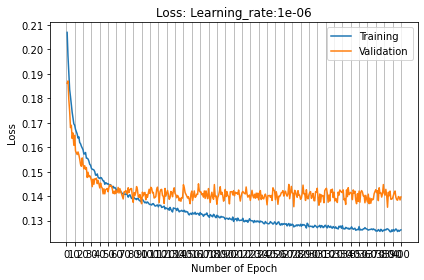

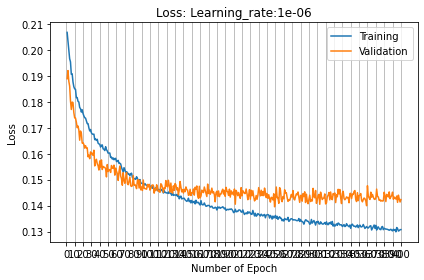

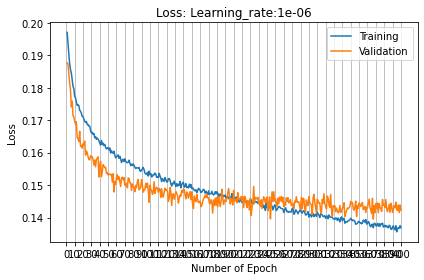

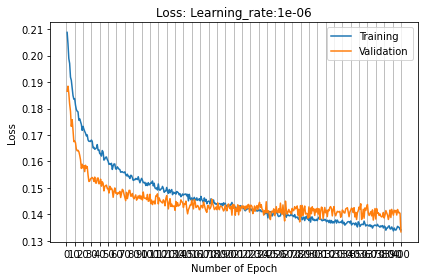

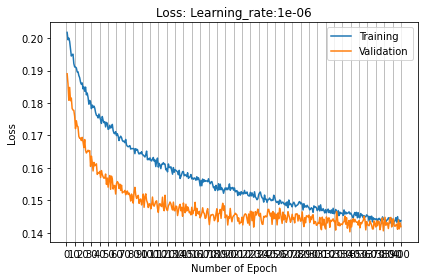

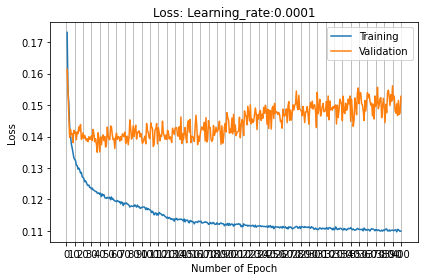

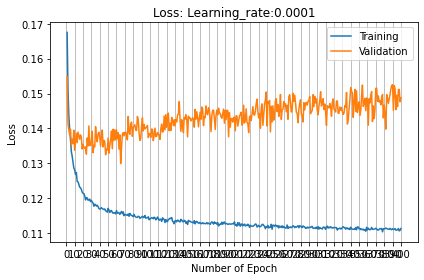

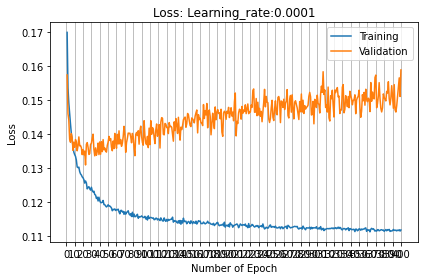

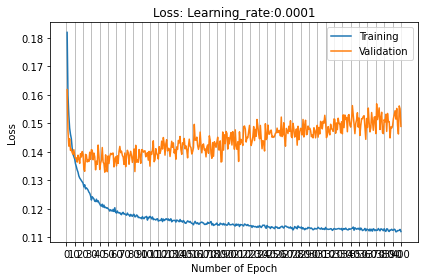

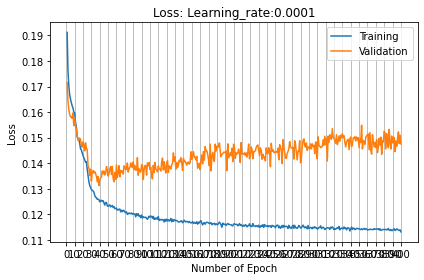

In [16]:
for lr in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]:
    for dr in [0]:

        #input parameter
        lr = lr
        # lr = 0.0001
        epoch = 400
        conv_dropout_rate=0
        dense_dropout_rate=dr
        weight_decay=0
        
        print("="*20)
        print("lr:", lr, "epoch:", epoch, "conv_dropout_rate:", conv_dropout_rate, "dense_dropout_rate:", dense_dropout_rate, "weight_decay:", weight_decay)
        print("="*20)
        ######################################

        model = Model(
        num_classes=6,
        num_filters=64,
        num_conv_layers=2,
        # num_dense_neurons=256, # batch_size = 64
        num_dense_neurons=128, # batch_size = 64
        num_dense_layers=2,
        return_logits=False,
        conv_dropout_rate=conv_dropout_rate,
        dense_dropout_rate=dense_dropout_rate
        ).to(device)

        # model = Model( #! way too memory intensive
        # num_classes=13,
        # num_filters=128,
        # num_conv_layers=2,
        # num_dense_neurons=64, # batch_size = 64

        # num_dense_layers=2,
        # return_logits=True,
        # conv_dropout_rate=0,
        # dense_dropout_rate=0
        # ).to(device)
        ## early stopping
        best_val_loss = float('inf')
        patience = 8  # How many epochs to wait after last time validation loss improved.
        patience_counter = 0
        lmbda = torch.tensor(1e-4, dtype = torch.float32)

        batch_size = 128
        # lr = 0.0085
        # lr = 0.00002

        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
        test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

        # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
        # test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
        # criterion = nn.MSELoss()
        # criterion = masked_weighted_MAE
        # criterion = masked_weighted_MSE
        criterion = weighted_cross_entropy_loss_fn


        # criterion = masked_MAE

        # criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
        # scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
        #%%

        torch.cuda.empty_cache()
        import gc; gc.collect()
        # ic.enable()
        ic.disable()

        train_epoch_loss = []
        test_epoch_loss = []

        for e in tqdm(range(1, epoch+1)):
            model.train()
            train_batch_loss = []
            test_batch_loss = []
            # print(f'Epoch {e}')
            for x_train, y_train in train_loader:
                x_batch = torch.squeeze(x_train, 0).to(device)
                y_batch = y_train.to(device)
                x_batch = x_batch.float()
                pred = model(x_batch.float())

                # break
                loss_train = criterion(pred,y_batch)
                train_batch_loss.append(loss_train)        
                optimizer.zero_grad()
                loss_train.backward()
                optimizer.step()
                # scheduler.step()  # Update the learning rate

            train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
            model.eval()
            with torch.no_grad():
                # print('>> test')
                for x_test, y_test in test_loader:
                    x_batch = torch.squeeze(x_test, 0).to(device)
                    x_batch = x_batch.float()
                    y_batch = y_test.to(device)
                    # print(x_batch.size())
                    # y_batch = torch.Tensor.float(y).to(device)
                    # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                    pred = model(x_batch.float())

                    # pred = pred.unsqueeze(0)
                    # print(pred[:10])
                    # print(y_batch[:10])

                    loss_test = criterion(pred,y_batch)
                    test_batch_loss.append(loss_test)
                test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

            if e % 50 == 0:
                print(f'Epoch {e}')
                print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
                print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
            # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
            # print(train_batch_loss)
            # print(test_batch_loss)
            # print(f"Training loss: {np.mean(train_batch_loss)}")
            # print(f"Validation loss: {np.mean(test_batch_loss)}")
            # #! implementing early stopping
            # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
            # print(f'Current val loss: {current_val_loss}')
            # print(f'Best val loss: {best_val_loss}')
            # if current_val_loss < best_val_loss:
            #     best_val_loss = current_val_loss
            #     patience_counter = 0  # reset patience counter
            #     # Save the best model
            #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

            # else:
            #     patience_counter += 1
            #     if patience_counter >= patience:
            #         print("Early stopping triggered")
            #         torch.save({
            #         'optimizer': optimizer.state_dict(),
            #         'model': model.state_dict(),
            #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
            #         break  # Early stopping
                
        print('==='*10)
        # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
        save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
                    train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

        fig, ax = plt.subplots()
        x = np.arange(1, epoch+1, 1)
        ax.plot(x, train_epoch_loss,label='Training')
        ax.plot(x, test_epoch_loss,label='Validation')
        ax.legend()
        ax.set_xlabel("Number of Epoch")
        ax.set_ylabel("Loss")
        ax.set_xticks(np.arange(0, epoch+1, 10))
        ax.set_title(f'Loss: Learning_rate:{lr}')
        # ax_2 = ax.twinx()
        # ax_2.plot(history["lr"], "k--", lw=1)
        # ax_2.set_yscale("log")
        # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
        ax.grid(axis="x")
        fig.tight_layout()
        fig.show()
        fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
        print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

        #%%
        testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
        testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

        model.eval()  # For inference

        ic.disable()
        model.eval()
        pred_list = []
        target_list  = []
        mse_list = []
        with torch.no_grad():
            for x_test, y_test in testing_loader1:
                xtest1 = x_test.to(device).float()
                ytest1 = y_test.to(device).float()
                pred = model(xtest1)
                pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
                target_list.append(y_test.detach().cpu().numpy())
        target_list = np.array(target_list).flatten()


        import numpy as np
        from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

        def calculate_metrics(true_labels, predictions):
            """
            Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

            Parameters:
            - true_labels: List or array of true labels
            - predictions: List or array of predicted labels

            Returns:
            - accuracy: Overall accuracy of predictions
            - f1: Weighted average F1 score
            - conf_matrix: Multiclass confusion matrix
            - mae: Mean Absolute Error of predictions
            """
            # Ensure inputs are numpy arrays for consistency
            true_labels = np.array(true_labels)
            predictions = np.array(predictions)

            # Calculate accuracy
            accuracy = accuracy_score(true_labels, predictions)

            # Calculate F1 score
            f1 = f1_score(true_labels, predictions, average='weighted')

            # Calculate confusion matrix
            conf_matrix = confusion_matrix(true_labels, predictions)

            # Calculate MAE
            mae = mean_absolute_error(true_labels, predictions)

            return accuracy, f1, conf_matrix, mae

        # Example usage
        # true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
        # predictions = [0, 2, 2, 1, 0, 0, 1, 0]

        accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

        print("======================")
        print("Model's Named Parameters:")
        # for name, param in model.named_parameters():
        #     print(f"Name: {name}")
        #     print(f"Shape: {param.size()}")
        #     print(f"Requires grad: {param.requires_grad}")
        #     print('-----')
        print("Optimizer details:")
        print(optimizer)
        for param_group in optimizer.param_groups:
            print("Learning rate:", param_group['lr'])
            print("Weight decay:", param_group.get('weight_decay', 'Not set'))
            
        print("======================")
        print(f"Accuracy: {accuracy}")
        print(f"Mae: {mae}")
        print(f"F1 Score: {f1}")
        print(f"conf_matrix: {conf_matrix}")
        print("======================")
        doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
        print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

## One cycle lr

In [21]:
len(train_loader)

64

In [ ]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0
dense_dropout_rate=0
# weight_decay=1e-8
weight_decay=0

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epoch)
######################################

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn


# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = loss_corn(pred, y_batch, 3, class_weights)

        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if ep % 20 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

## Cyclical lr

In [ ]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0.05
dense_dropout_rate=0.5
weight_decay=1e-8

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=0.001)
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = loss_corn(pred, y_batch, 3, class_weights)

        train_batch_loss.append(loss_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [19]:
def loss_corn(logits, y_train, num_classes):
    sets = []
    for i in range(num_classes-1):
        label_mask = y_train > i-1
        label_tensor = (y_train[label_mask] > i).to(torch.int64)
        sets.append((label_mask, label_tensor))

    num_examples = 0
    losses = 0.
    for task_index, s in enumerate(sets):
        train_examples = s[0]
        train_labels = s[1]

        if len(train_labels) < 1:
            continue

        num_examples += len(train_labels)
        pred = logits[train_examples, task_index]

        loss = -torch.sum(F.logsigmoid(pred)*train_labels
                          + (F.logsigmoid(pred) - pred)*(1-train_labels)
                          )
        losses += loss
    return losses/num_examples


In [20]:
pred  = torch.tensor([[0.0000, 0.5111],
        [0.1329, 1.1051]], device='cuda:0')
target = torch.tensor([0, 0], device='cuda:0')


In [22]:
out = loss_corn(pred, target, 3)
print(out)

tensor(0.7275, device='cuda:0')
